In [5]:
# Loading the cleaned datasets
import pandas as pd

collision_df = pd.read_csv("clean_collision_data.csv")
esa_df = pd.read_csv("clean_esa_data.csv")
full_satcat_df = pd.read_csv("clean_full_satcat_data.csv")
lost_objects_df = pd.read_csv("clean_lost_objects_data.csv")
loe_objects_df = pd.read_csv("clean_leo_objects_data.csv")

# Printing for preview
print("ESA:", esa_df.shape)
print("SATCAT:", full_satcat_df.shape)
print("LOST:", lost_objects_df.shape)
print("LEO:", loe_objects_df.shape)
print("COLLISION:", collision_df.shape)

ESA: (68124, 7)
SATCAT: (58503, 17)
LOST: (2539, 8)
LEO: (22956, 22)
COLLISION: (80377, 14)


# **Step 1: Combining Key Features Across Datasets**

Standardizing the column names

Adding a source column to keep track of each dataset and combining them using pd.concat() on selected columns like object name, type/class, and maybe epoch or launch date.

In [6]:
# Adding a source column to each
esa_df['source'] = 'ESA'
full_satcat_df['source'] = 'SATCAT'
lost_objects_df['source'] = 'LOST'
loe_objects_df['source'] = 'LEO'

In [8]:
# Adding base class mapping to align object types
base_class_mapping = {
    'PAYLOAD': 'PAYLOAD',
    'DEBRIS': 'DEBRIS',
    'ROCKET BODY': 'ROCKET BODY',
    'ROCKETBODY': 'ROCKET BODY',
    'UNKNOWN': 'UNKNOWN',
    'OTHER': 'UNKNOWN',
    'TBA': 'UNKNOWN',
    'CROSSOVER': 'UNKNOWN'
}

# Applying mapping to full_satcat_df and lost_objects_df
full_satcat_df['object_type_base'] = full_satcat_df['object_type'].str.upper().map(base_class_mapping).fillna('UNKNOWN')
lost_objects_df['object_type_base'] = lost_objects_df['object_type'].str.upper().map(base_class_mapping).fillna('UNKNOWN')

In [10]:
# Standardizing and selecting the relevant columns
esa_df_small = esa_df[['name', 'objectClass_base', 'firstEpoch', 'source']].rename(columns={
    'name': 'object_name',
    'objectClass_base': 'object_type',
    'firstEpoch': 'timestamp'
})

full_satcat_df_small = full_satcat_df[['object_name', 'object_type_base', 'source']].rename(columns={
    'object_type_base': 'object_type'
})

lost_objects_df_small = lost_objects_df[['satellite_name', 'object_type_base', 'launch_date', 'source']].rename(columns={
    'satellite_name': 'object_name',
    'object_type_base': 'object_type',
    'launch_date': 'timestamp'
})

loe_objects_df_small = loe_objects_df[['launch', 'site', 'source']].rename(columns={
    'launch': 'timestamp',
    'site': 'object_name'
})
loe_objects_df_small['object_type'] = 'UNKNOWN'  # placeholder

In [12]:
# Combining all into one DataFrame
combined_df = pd.concat([
    esa_df_small,
    full_satcat_df_small,
    lost_objects_df_small,
    loe_objects_df_small
], ignore_index=True)

# Dropping the rows with missing object_type
combined_df = combined_df.dropna(subset=['object_type'])

print("Combined dataset shape:", combined_df.shape)
combined_df.head()

Combined dataset shape: (152122, 4)


,object_name,object_type,timestamp,source
0,Calsphere 1,PAYLOAD,1964-10-06,ESA
1,Calsphere 2,PAYLOAD,1964-10-06,ESA
2,LCS 1,PAYLOAD,1965-05-06,ESA
3,Tempsat 1,PAYLOAD,1965-08-13,ESA
4,Calsphere 4,PAYLOAD,1965-08-13,ESA


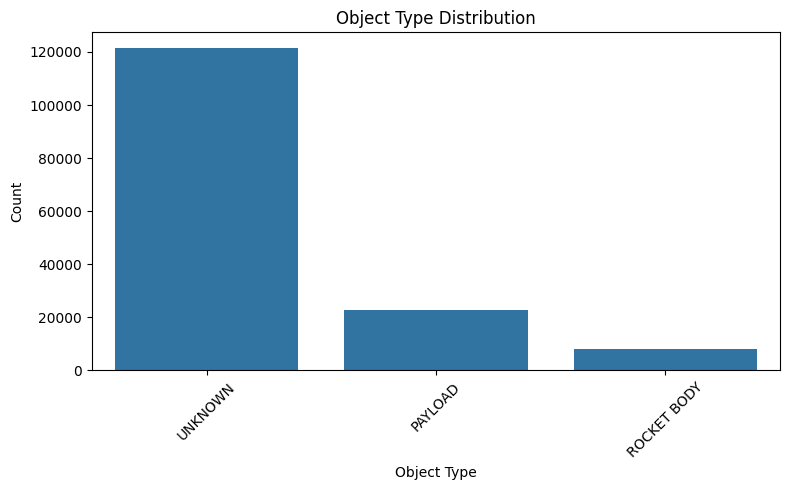

In [ ]:
# Ploting object type distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=combined_df, x='object_type', order=combined_df['object_type'].value_counts().index)
plt.title("Object Type Distribution")
plt.xlabel("Object Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

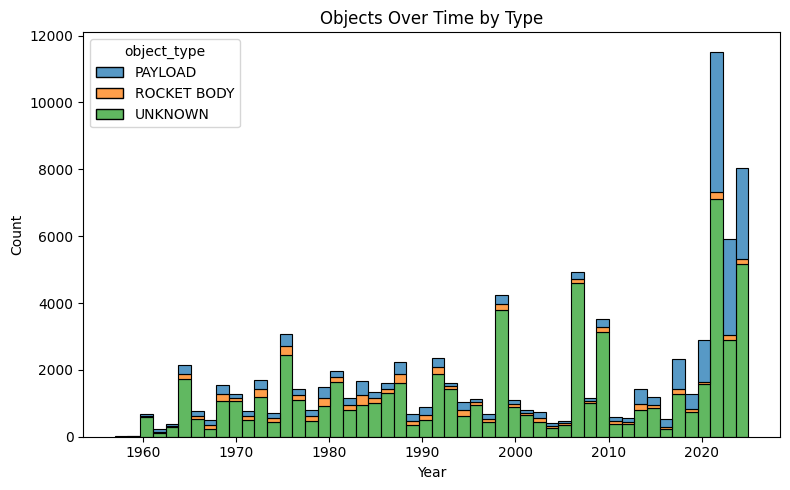

In [ ]:
# Ploting object frequency by year
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], errors='coerce')

# Drop rows with invalid dates (NaT)
combined_df = combined_df.dropna(subset=['timestamp'])

combined_df['year'] = combined_df['timestamp'].dt.year
plt.figure(figsize=(8, 5))
sns.histplot(data=combined_df, x='year', hue='object_type', multiple='stack', bins=50)
plt.title("Objects Over Time by Type")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encoding the object type and source
combined_df['object_type_encoded'] = LabelEncoder().fit_transform(combined_df['object_type'])
combined_df['source_encoded'] = LabelEncoder().fit_transform(combined_df['source'])

# Final dataframe for clustering
features_df = combined_df[['year', 'object_type_encoded', 'source_encoded']].dropna()

# Saving to CSV
features_df.to_csv("space_objects_kmeans.csv", index=False)